In [2]:
import numpy as np
import random

import torch
import torch.nn as nn
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pylab as plt
import wandb
from torch.utils.data import Dataset
import gzip

import glob
from glob import glob
import nibabel as nb
import imageio

from dataclasses import dataclass
from ResnetGenerator import ResnetGenerator
from NLayerDiscriminator import NLayerDiscriminator

@dataclass
class Parameters:
    bs : int
    n_channels : int
    ngf : int
    ndf : int
    size : int
    gen_n_down : int
    gen_n_blocks : int
    dis_n_down : int
    lr : float
    beta1 : float

class mriDataset(Dataset):
    def __init__(self, input_dir):
        self.mri_files = glob(input_dir+'/*/m*')
    
    def __getitem__(self, idx):
        print(idx)
        vol = round(idx/80)
        mri_vol = gzip.GzipFile(self.mri_files[vol],'r');
        
        slice = idx-vol*80;
        mri_img = np.load(mri_vol)[:,:,150+slice]

        return torch.from_numpy(mri_img)

class sosDataset(Dataset):
    def __init__(self, input_dir):
        self.sos_files = glob(input_dir+'/*/V*')
    
    def __getitem__(self, idx):
        vol = round(idx/80)
        sos_vol = gzip.GzipFile(self.sos_files[vol],'r');
        
        slice = idx-vol*80;
        sos_img = np.load(sos_vol)[:,:,150+slice]

        return torch.from_numpy(sos_img)


def init_dataset(bs, test=False):
    if(test == False): path = '../../../../../media/clararg/8TB HDD/Data/Ultrasound-MRI_volumes/train';
    if(test == True): path = '../../../../../media/clararg/8TB HDD/Data/Ultrasound-MRI_volumes/test';
    dataloader_mri = mriDataset(path);
    dataloader_sos = sosDataset(path);
    
    return dataloader_mri, dataloader_sos

def init_models(p):
    G_A2B = ResnetGenerator(input_nc=p.n_channels,output_nc=p.n_channels,ngf=p.ngf,norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=p.gen_n_blocks, n_downsampling=p.gen_n_down, padding_type='reflect')
    G_B2A = ResnetGenerator(input_nc=p.n_channels,output_nc=p.n_channels,ngf=p.ngf,norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=p.gen_n_blocks, n_downsampling=p.gen_n_down, padding_type='reflect')
    D_A = NLayerDiscriminator(input_nc=p.n_channels,ndf=p.ndf,n_layers=p.dis_n_down, norm_layer=nn.BatchNorm2d)
    D_B = NLayerDiscriminator(input_nc=p.n_channels,ndf=p.ndf,n_layers=p.dis_n_down, norm_layer=nn.BatchNorm2d)

    optimizer_G_A2B = torch.optim.Adam(G_A2B.parameters(), lr=p.lr, betas=(p.beta1, 0.999))
    optimizer_G_B2A = torch.optim.Adam(G_B2A.parameters(), lr=p.lr, betas=(p.beta1, 0.999))

    optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=p.lr, betas=(p.beta1, 0.999))
    optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=p.lr, betas=(p.beta1, 0.999))

    return G_A2B, G_B2A, D_A, D_B, optimizer_G_A2B, optimizer_G_B2A, optimizer_D_A, optimizer_D_B
def LSGAN_D(real, fake):
  return (torch.mean((real - 1)**2) + torch.mean(fake**2))
def LSGAN_G(fake):
  return  torch.mean((fake - 1)**2)

def plot_images_test(dataloader_mri, dataloader_sos, epoch): 
    batch_a_test = next(iter(dataloader_mri))[0].unsqueeze(0).unsqueeze(0).to(device)
    real_a_test = batch_a_test.cpu().detach()
    fake_b_test = G_A2B(batch_a_test).cpu().detach()

    batch_b_test = next(iter(dataloader_sos))[0].unsqueeze(0).unsqueeze(0).to(device)
    real_b_test = batch_b_test.cpu().detach()
    fake_a_test = G_B2A(batch_b_test ).cpu().detach()

    fake_a_error = (real_a_test - fake_a_test)[0,0,:,:]
    fake_b_error = (real_b_test - fake_b_test)[0,0,:,:]

    plt.subplots(1,2)
    plt.subplot(1,2,1)
    plt.imshow(fake_a_error,cmap='PiYG'); plt.colorbar()
    plt.clim(-1,1)
    plt.title('Fake MRI MAE')
    plt.subplot(1,2,2)
    plt.imshow(fake_b_error,cmap='PiYG'); plt.colorbar()
    plt.clim(-1,1)
    plt.title('Fake SoS MAE')
    # plt.show(block=False)
    plt.savefig('/home/oab18/Projects/MRI_Project/3d_cycleGAN/Images/training_'+name+'/err_epoch'+str(epoch)+'.png')
    
    

In [3]:
dataloader_mri, dataloader_sos = init_dataset(1, False)

In [4]:
input_dir = '../../../../../media/clararg/8TB HDD/Data/Ultrasound-MRI_volumes/train';
mri_files = glob(input_dir+'/*/m*')

vol = round(300/80)
mri_vol = gzip.GzipFile(mri_files[vol],'r');

slice = 2-vol*80;
mri_img2 = np.load(mri_vol)[:,:,150+slice]

IndexError: list index out of range

In [5]:
it = iter(dataloader_mri)
a = next(it);
b = next(it);

0


StopIteration: 

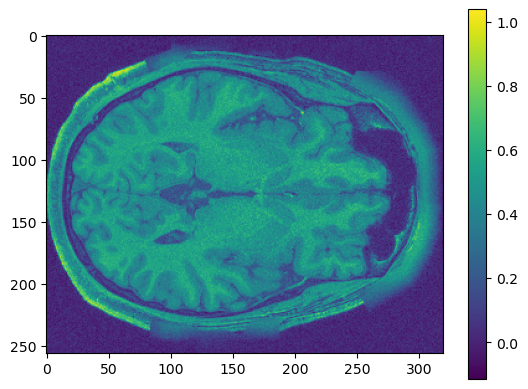

In [77]:
b = b/torch.max(b).item()
b = b + (0.001**0.5)*torch.randn(256,320)
plt.imshow(b); plt.colorbar()

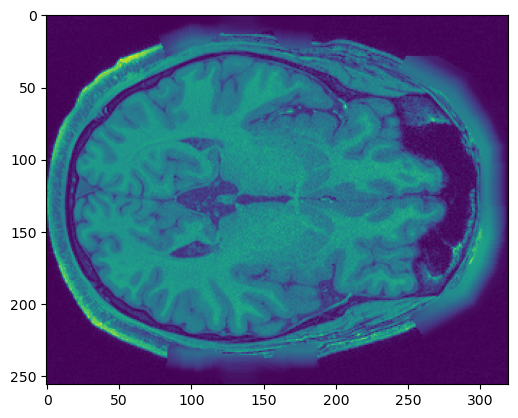

In [41]:
plt.imshow(tmp)

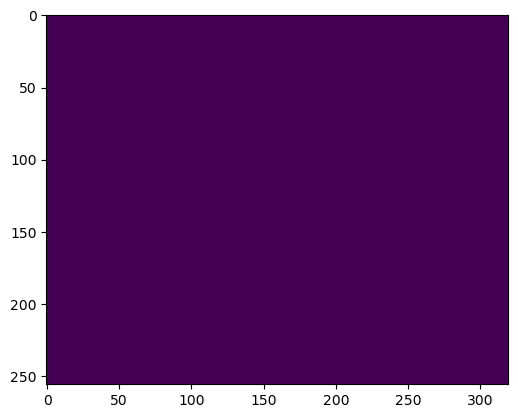

In [19]:
plt.imshow(a-b)

In [13]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
    torch.cuda.manual_seed_all(999)
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [14]:
p = Parameters(bs=1, n_channels=1, ngf=128, ndf=16, size=64, gen_n_down=2, gen_n_blocks=6, dis_n_down=2, lr=0.0002, beta1=0.5)
G_A2B, G_B2A, D_A, D_B, optimizer_G_A2B, optimizer_G_B2A, optimizer_D_A, optimizer_D_B = init_models(p)

G_A2B.to(device)
G_B2A.to(device)
D_A.to(device)
D_B.to(device)

NLayerDiscriminator(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(64, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [15]:
mri = next(iter(dataloader_mri))
mri = mri.unsqueeze(0).unsqueeze(0)
mri = mri.to(device)
print(mri.is_cuda)
print(mri.shape)

True
torch.Size([1, 1, 256, 320])


In [8]:
fake_sos = G_A2B(mri).detach().numpy();
plt.imshow(fake_sos[0,0,:,:])

: 

: 